In [44]:
import numpy as np
import os as os
import sys as sys
import multiprocessing as mp
import matplotlib.pyplot as plt

import pandas as pd
import socket

### For Arial Font
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'   # Set the defaul
rcParams['font.sans-serif'] = ['Arial']  # Make sure to have the font installed (it is on cluster for Harald)

#######################################################
### Pick the right path (whether on cluster or at home)
socket_name = socket.gethostname()
print(socket_name)
if socket_name == "VioletQueen":
    path = "/home/harald/git/HAPSBURG/"   # The Path on Harald's machine
elif socket_name.startswith("midway2"):
    print("Midway jnovmbre partition detected.")
    path = "/project2/jnovembre/hringbauer/HAPSBURG/"  # The Path on Midway Cluster
    sys.path.append("/project2/jnovembre/hringbauer/HAPSBURG/package/")
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")
    
os.chdir(path)  # Set the right Path (in line with Atom default)
print(os.getcwd()) # Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(f"CPU Count: {mp.cpu_count()}")

### Import hapsburg Packages
from hapsburg.PackagesSupport.roh_expectations import Expected_Roh
from hapsburg.PackagesSupport.fit_ne import MLE_ROH_Ne, inds_roh_from_pdf

midway2-0401.rcc.local
Midway jnovmbre partition detected.
/project2/jnovembre/hringbauer/HAPSBURG
CPU Count: 28


In [114]:
def roh_vec_from_roh_df(df, split_names=[],
                        rep_col="replicate", length_col="lengthM"):
    """Generates a ROH vector from a concatentation of ROH 
    dataframes, by splitting up the individuals"""
    roh_vec = []
    
    for s in split_names:
        df_t = df[df[rep_col] == s]
        roh = df_t[length_col].values
        roh_vec.append(roh)
    return roh_vec


def load_res_df_msprime(test_nes = [200, 500, 1000, 3000], reps = 20, n_ind = 10,
                loadfolder = "./Simulated/msprime/fixed_Ne_gaps_merged/"):
    """Load the Results over replicates and return dataframe"""
    res_dfs = [] # Vector of Results
    for ne in test_nes:
        print(f"Analyzing 2Ne={ne}...")
        ne_dip = int(ne/2)

        df_res_rep = []

        for j in range(reps):
            savepath = loadfolder + str(ne_dip) + "_" + str(j) + ".tsv" 
            df_all = pd.read_csv(savepath, sep="\t")

            roh_vec = roh_vec_from_roh_df(df_all, split_names=range(n_ind))
            roh_vec = [roh * 100 for roh in roh_vec]

            mle = MLE_ROH_Ne(start_params=500, endog=roh_vec, 
                        error_model=False, output=False)
            fit = mle.fit(disp=False)
            summary = fit.summary()
            df_res = mle.get_summ_as_df()

            df_res_rep.append(df_res)
        df_t = pd.concat(df_res_rep)
        df_t["ne"]=ne
        df_t["n_ind"]=n_ind
        res_dfs.append(df_t)
    df = pd.concat(res_dfs)
    return df

########################################
### Plot the results

def plot_reps_inferred(df, test_nes, reps, figsize=(5,5), c2=["red", "orange"],
                      lw_true = 3, c_true = "green", title="", ylim=[], yscale="linear",
                      savepath="./figures/ne_infer/under_model.png"):
    """Plot Replicate Inferences"""
    colors = ([c2[0]] * reps + [c2[1]] * reps) * int(len(test_nes) / 2)

    x = np.arange(len(df))

    plt.figure(figsize=figsize)
    ax = plt.gca()
    ax.scatter(x, df["coef"], c= colors, ec="k", label="ROH Estimate")
    ax.errorbar(x, df["coef"], 1.96*df["std err"],  fmt='none', color="gray", zorder=0, label="95% CI")

    ax.set_xlabel("Replicate")
    ax.set_ylabel("Inferred 2Ne")
    ax.set_title(title)
    if len(ylim)>0:
        ax.set_ylim(ylim)
    if len(yscale)>0:
        ax.set_yscale(yscale)

    for i,ne in enumerate(test_nes):
        if i==0:
            label=f"True $2N_e$"
        else:
            label=""
        ax.hlines(ne, i*reps, (i+1)*reps, color=c_true, lw=lw_true, label=label)

    ax.legend(loc="upper left")

    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches = 'tight', pad_inches = 0, dpi=300)
        print(f"Saved figure to {savepath}") 
    plt.show()

In [46]:
df_all = pd.read_csv("./Simulated/msprime/fixed_Ne_all_rec/100_0.tsv", sep="\t")
roh_vec = roh_vec_from_roh_df(df_all, split_names=range(10))
roh_vec = [roh * 100 for roh in roh_vec]

### Do a Fit of the roh_vec

In [48]:
mle = MLE_ROH_Ne(start_params=500, endog=roh_vec, 
                    error_model=False, output=False)
fit = mle.fit(disp=True)
summary = fit.summary()
df_res = mle.get_summ_as_df()
df_res

Optimization terminated successfully.
         Current function value: 67.779746
         Iterations: 24
         Function evaluations: 48


,coef,std err,z,P>|z|,[0.025,0.975]
const,217.9794,11.762,18.533,0.0,194.927,241.032


# Analyze Multiple Runs

Analyzing 2Ne=200...
Analyzing 2Ne=500...
Analyzing 2Ne=1000...
Analyzing 2Ne=3000...
CPU times: user 11.3 s, sys: 15.3 ms, total: 11.3 s
Wall time: 11.8 s


## Full Arg
Each recombination event counts

In [125]:
df = load_res_df_msprime(test_nes = [200, 500, 1000, 3000], reps = 20, n_ind = 10,
                loadfolder = "./Simulated/msprime/fixed_Ne_all_rec/")
df = df.sort_values(by=["ne", "coef"])

Analyzing 2Ne=200...
Analyzing 2Ne=500...
Analyzing 2Ne=1000...
Analyzing 2Ne=3000...


Saved figure to ./figures/ne_infer/ms_prime_all_recs.png


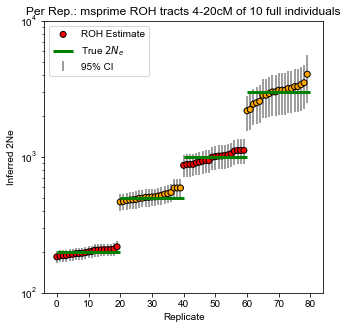

In [127]:
plot_reps_inferred(df, test_nes, reps, ylim=[100,1e4], yscale="log",
                   title="Per Rep.: msprime ROH tracts 4-20cM of 10 full individuals",
                   savepath="./figures/ne_infer/ms_prime_all_recs.png") # ./figures/ne_infer/ms_prime_all_recs.png

### Gaps Merged (t=100 and less, 0.01 cM gaps merged)

In [129]:
df = load_res_df_msprime(test_nes = [200, 500, 1000, 3000], reps = 20, n_ind = 10,
                loadfolder = "./Simulated/msprime/fixed_Ne_gaps_merged/")
df = df.sort_values(by=["ne", "coef"])

Analyzing 2Ne=200...
Analyzing 2Ne=500...
Analyzing 2Ne=1000...
Analyzing 2Ne=3000...


Saved figure to ./figures/ne_infer/ms_prime_gaps_merged.png


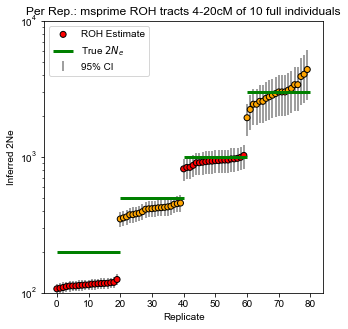

In [130]:
plot_reps_inferred(df, test_nes, reps, ylim=[100,1e4], yscale="log",
                   title="Per Rep.: msprime ROH tracts 4-20cM of 10 full individuals",
                   savepath="./figures/ne_infer/ms_prime_gaps_merged.png")

# Area 51

In [54]:
[np.sum(roh) for roh in roh_vec]

[193.98948402008432,
 145.0874726271332,
 212.55502284870045,
 240.30634526438436,
 142.28458278866287,
 122.92410264734299,
 154.07831708933531,
 169.01007298102644,
 199.94575832689017,
 166.4290910110789]